In [1]:
from matplotlib import pyplot
from math import pi
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
import numba
from numba import jit

In [2]:
def uex(t,X,Y):
    return -numpy.exp(-2*t)*numpy.cos(X)*numpy.sin(Y)

def vex(t,X,Y):
    return numpy.exp(-2*t)*numpy.sin(X)*numpy.cos(Y)

def pex(t,X,Y):
    return -numpy.exp(-4*t)/4.*(numpy.cos(2*X)+numpy.cos(2*Y))

In [3]:
def Fc1(u,v,dx,dy):
    F=numpy.zeros(numpy.shape(u))
    F[1:-1,1:-1]=-((u[1:-1,1:-1]+u[1:-1,2:])**2-(u[1:-1,1:-1]+u[1:-1,:-2])**2)/(4*dx)-\
                ((u[1:-1,1:-1]+u[2:,1:-1])*(v[1:-1,2:]+v[1:-1,1:-1])-(u[1:-1,1:-1]+u[:-2,1:-1])*(v[:-2,2:]+v[:-2,1:-1]))/(4*dy)
        
    F[:,0]=F[:,-2]
    F[:,-1]=F[:,1]
    F[0,:]=F[-2,:]
    F[-1,:]=F[-1,:]
    return F

In [4]:
def Fv1(u,v,dx,dy):
    F=numpy.zeros(numpy.shape(u))
    F[1:-1,1:-1]=(u[1:-1,2:]-2*u[1:-1,1:-1]+u[1:-1,:-2])/dx**2+(u[2:,1:-1]-2*u[1:-1,1:-1]+u[:-2,1:-1])/dy**2
    
    F[:,0]=F[:,-2]
    F[:,-1]=F[:,1]
    F[0,:]=F[-2,:]
    F[-1,:]=F[-1,:]
    return F

In [5]:
def Fp1(p,dx,dy):
    F=numpy.zeros(numpy.shape(p))
    F[1:-1,1:-1]=-(p[1:-1,2:]-p[1:-1,1:-1])/dx
    F[:,0]=F[:,-2]
    F[:,-1]=F[:,1]
    F[0,:]=F[-2,:]
    F[-1,:]=F[-1,:]
    return F

In [6]:
def Fc2(u,v,dx,dy):
    F=numpy.zeros((numpy.shape(u)))
    F[1:-1,1:-1]=-((u[2:,1:-1]+u[1:-1,1:-1])*(v[1:-1,1:-1]+v[1:-1,2:])-(u[2:,:-2]+u[1:-1,:-2])*(v[1:-1,1:-1]+v[1:-1,:-2]))/(4*dx)-\
                 ((v[1:-1,1:-1]+[v[2:,1:-1]])**2-(v[1:-1,1:-1]+v[:-2,1:-1])**2)/(4*dy)
        
    F[:,0]=F[:,-2]
    F[:,-1]=F[:,1]
    F[0,:]=F[-2,:]
    F[-1,:]=F[-1,:]
    return F

In [7]:
def Fv2(u,v,dx,dy):
    F=numpy.zeros((numpy.shape(u)))
    F[1:-1,1:-1]=(v[1:-1,2:]-2*v[1:-1,1:-1]+v[1:-1,:-2])/dx**2+(v[2:,1:-1]-2*v[1:-1,1:-1]+v[:-2,1:-1])/dy**2
        
    F[:,0]=F[:,-2]
    F[:,-1]=F[:,1]
    F[0,:]=F[-2,:]
    F[-1,:]=F[-1,:]
    return F

In [8]:
def Fp2(p,dx,dy):
    F=numpy.zeros((numpy.shape(p)))
    F[1:-1,1:-1]=-(p[2:,1:-1]-p[1:-1,1:-1])/dy
        
    F[:,0]=F[:,-2]
    F[:,-1]=F[:,1]
    F[0,:]=F[-2,:]
    F[-1,:]=F[-1,:]
    return F

In [9]:
@jit
def poisson(f,res_target,omega,t):
    nj,ni=numpy.shape(f)-numpy.array((1,1))
    dx=2*pi/(ni-1)
    dy=2*pi/(nj-1)
    x=numpy.linspace(-dx/2,2*pi+dx/2,ni+1)
    y=numpy.linspace(-dy/2,2*pi+dy/2,nj+1)
    X,Y=numpy.meshgrid(x,y)
    
    p=numpy.zeros(numpy.shape(f))
    res=numpy.zeros(numpy.shape(f))
    
    p_ex=pex(t,X,Y)
    res_max=1e3
    n=0
    while res_max>res_target:
        
        for j in range(1,nj):
            for i in range(1,ni):
                p[j,i]=omega/(2*(dx**2+dy**2))*((p[j,i-1]+p[j,i+1])*dy**2+\
                       (p[j-1,i]+p[j+1,i])*dx**2-f[j,i]*dx**2*dy**2)+\
                       (1-omega)*p[j,i]
        p[0,:]=p[1,:]
        p[-1,:]=p[-2,:]
        p[:,0]=p[:,1]
        p[:,-1]=p[:,-2]
        n+=1
        
        for j in range(1,nj):
            for i in range(1,ni):
                res[j,i]=numpy.abs(f[j,i]-(p[j,i-1]-2*p[j,i]+p[j,i+1])/dx**2-\
                                  (p[j-1,i]-2*p[j,i]+p[j+1,i])/dy**2)
        res_max=numpy.max(res)
    
    return p

In [10]:
@jit
def getuv(w1,w2,p,dx,dy,dt):
    u=w1+Fp1(p,dx,dy)*dt
    v=w2+Fp2(p,dx,dy)*dt
    
    u[0,:]=-u[1,:]
    u[-1,:]=-u[-2,:]
    u[:,0]=u[:,-2]
    u[:,-1]=u[:,1]

    v[0,:]=v[-2,:]
    v[-1,:]=v[1,:]
    v[:,0]=-v[:,1]
    v[:,-1]=-v[:,-2]
    return u,v

In [11]:
@jit
def error(p,p_ex):
    nj,ni=numpy.shape(p)-numpy.array((1,1))
    err=numpy.zeros(numpy.shape(p))
    for j in range(nj+1):
        for i in range(ni+1):
            err[j,i]=numpy.abs(p[j,i]-p_ex[j,i])
    err_max=numpy.max(err)
    return err_max

In [12]:
@jit
def RK3(ni,nj,dt):
    T=2.
    nt=int(T/dt)
    t=0
    dx=2.*pi/(ni-1)
    dy=2.*pi/(nj-1)
    x=numpy.linspace(-dx/2,2*pi+dx/2,ni+1)
    y=numpy.linspace(-dy/2,2*pi+dy/2,nj+1)
    xu=numpy.linspace(0,2*pi+dx,ni+1)
    yu=numpy.linspace(-dy/2,2*pi+dy/2,nj+1)
    xv=numpy.linspace(-dx/2,2*pi+dx/2,ni+1)
    yv=numpy.linspace(0,2*pi+dy,nj+1)

    X,Y=numpy.meshgrid(x,y)
    Xu,Yu=numpy.meshgrid(xu,yu)
    Xv,Yv=numpy.meshgrid(xv,yv)

    u0=uex(0,Xu,Yu)
    v0=vex(0,Xv,Yv)
    p0=pex(0,X,Y)
            
    u=u0.copy()
    v=v0.copy()
    p=p0.copy()
    res=numpy.zeros((nj+1,ni+1))
    
    while t<T:
        G1=numpy.zeros((nj+1,ni+1))
        G2=numpy.zeros((nj+1,ni+1))
        w1=numpy.zeros((nj+1,ni+1))
        w2=numpy.zeros((nj+1,ni+1))
        f=numpy.zeros((nj+1,ni+1))
        
        #from t to t+dt/3
        t+=dt/3
        G1=Fc1(u,v,dx,dy)+Fv1(u,v,dx,dy)
        G2=Fc2(u,v,dx,dy)+Fv2(u,v,dx,dy)
        w1=u+dt/3*G1
        w2=v+dt/3*G2
        
        f[1:-1,1:-1]=3./dt*((w1[1:-1,1:-1]-w1[1:-1,:-2])/dx+(w2[1:-1,1:-1]-w2[:-2,1:-1])/dy)
        
        p=poisson(f,1e-6,1.99,t)
        
        u,v=getuv(w1,w2,p,dx,dy,dt/3)
        
        #from t+dt/3 to t+3dt/4
        t+=5./12*dt
        G1=-5./9*G1+Fc1(u,v,dx,dy)+Fv1(u,v,dx,dy)
        G2=-5./9*G2+Fc2(u,v,dx,dy)+Fv2(u,v,dx,dy)
        w1=u+dt*15./16*G1
        w2=v+dt*15./16*G2
        
        f[1:-1,1:-1]=12./5/dt*((w1[1:-1,1:-1]-w1[1:-1,:-2])/dx+(w2[1:-1,1:-1]-w2[:-2,1:-1])/dy)
                
        p=poisson(f,1e-6,1.99,t)
        
        u,v=getuv(w1,w2,p,dx,dy,5.*dt/12)
        
        #from t+3dt/4 to t+dt
        t+=dt/4
        G1=-153./128*G1+Fc1(u,v,dx,dy)+Fv1(u,v,dx,dy)
        G2=-153./128*G2+Fc2(u,v,dx,dy)+Fv2(u,v,dx,dy)
        w1=u+dt*8./15*G1
        w2=v+dt*8./15*G2
        
        f[1:-1,1:-1]=4./dt*((w1[1:-1,1:-1]-w1[1:-1,:-2])/dx+(w2[1:-1,1:-1]-w2[:-2,1:-1])/dy)
                
        p=poisson(f,1e-6,1.99,t)
    
        u,v=getuv(w1,w2,p,dx,dy,dt/4)
        if (t*1000)%10==0:
            print(error(u,uex(t,Xu,Yu)),error(v,vex(t,Xv,Yv)),error(p,pex(t,X,Y)))
    
    A=numpy.array([u,v,p])
    return A

In [14]:
def grid_p(ni,nj):
    dx=2*pi/(ni-1)
    dy=2*pi/(nj-1)
    x=numpy.linspace(-dx/2,2*pi+dx/2,ni+1)
    y=numpy.linspace(-dy/2,2*pi+dy/2,nj+1)
    X,Y=numpy.meshgrid(x,y)
    return X,Y

def grid_u(ni,nj):
    dx=2*pi/(ni-1)
    dy=2*pi/(nj-1)
    xu=numpy.linspace(0,2*pi+dx,ni+1)
    yu=numpy.linspace(-dy/2,2*pi+dy/2,nj+1)
    X,Y=numpy.meshgrid(xu,yu)
    return X,Y

def grid_v(ni,nj):
    dx=2*pi/(ni-1)
    dy=2*pi/(nj-1)
    xv=numpy.linspace(-dx/2,2*pi+dx/2,ni+1)
    yv=numpy.linspace(0,2*pi+dy,nj+1)
    X,Y=numpy.meshgrid(xv,yv)
    return X,Y

In [13]:
A1=RK3(41,41,0.005)

4.01517888786e-05 4.0151790473e-05 0.197808619418
7.87150583632e-05 7.87150594048e-05 0.190030586869
0.000151263390249 0.000151263391312 0.175380004586
0.000279290351056 0.000279290351575 0.14938021845
0.000633510619822 0.000633510612551 0.0729323196903
0.000505846892728 0.000505846891645 0.00269795116451


In [15]:
X,Y=grid_p(41,41)
Xu,Yu=grid_u(41,41)
Xv,Yv=grid_v(41,41)
u_err=error(A1[0],uex(2,Xu,Yu))
v_err=error(A1[1],vex(2,Xv,Yv))
p_err=error(A1[2],pex(2,X,Y))
    
print('u error={}'.format(u_err))
print('v error={}'.format(v_err))
print('p error={}'.format(p_err))

u error=0.00015066779533129404
v error=0.00015066780704900765
p error=7.26022896998316e-05


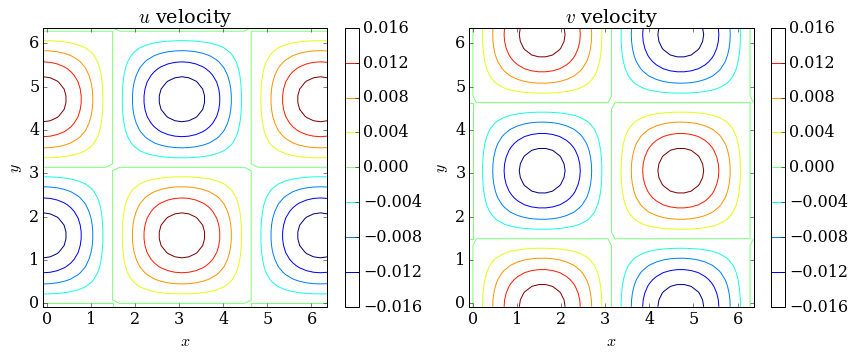

In [16]:
pyplot.figure(figsize=(14,5))
pyplot.subplot(121)
pyplot.contour(X,Y,A1[0],10)
pyplot.colorbar()
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.title('$u$ velocity')

pyplot.subplot(122)
pyplot.contour(X,Y,A1[1],10)
pyplot.colorbar()
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.title('$v$ velocity');

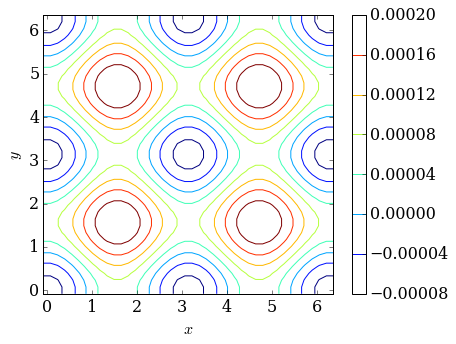

In [18]:
pyplot.figure(figsize=(6.5,5))
pyplot.contour(X,Y,A1[2],10)
pyplot.colorbar()
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')